# Importing Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Set style
sns.set(style="whitegrid")

# Importing Data Set

In [2]:
df=pd.read_csv("Credit card transactions - India - Simple.csv", index_col='index')

In [3]:
df.head()

City       Date  Card Type Exp Type Gender  Amount
index                                                                     
0               Delhi, India  29-Oct-14       Gold    Bills      F   82475
1      Greater Mumbai, India  22-Aug-14   Platinum    Bills      F   32555
2           Bengaluru, India  27-Aug-14     Silver    Bills      F  101738
3      Greater Mumbai, India  12-Apr-14  Signature    Bills      F  123424
4           Bengaluru, India   5-May-15       Gold    Bills      F  171574

In [4]:
df.shape

(26052, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26052 entries, 0 to 26051
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       26052 non-null  object
 1   Date       26052 non-null  object
 2   Card Type  26052 non-null  object
 3   Exp Type   26052 non-null  object
 4   Gender     26052 non-null  object
 5   Amount     26052 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


# Details about the dataset

In [6]:
Card_Type = df['Card Type'].unique()
print('Card Types = ', Card_Type)
Exp_Type = df['Exp Type'].unique()
print('Expense Types = ', Exp_Type)
City = len(df['City'].unique())
print('Cities = ', City)

Card Types =  ['Gold' 'Platinum' 'Silver' 'Signature']
Expense Types =  ['Bills' 'Food' 'Entertainment' 'Grocery' 'Fuel' 'Travel']
Cities =  986


In [7]:
#Check duplicate Values
df.duplicated().sum()

0

In [ ]:
#Object to Date datatype Conversion

In [40]:
df["Date"]=pd.to_datetime(df["Date"])
df.dtypes

City                 object
Date         datetime64[ns]
Card Type            object
Exp Type             object
Gender               object
Amount              float64
Month                object
dtype: object

# Mostly used cards 

In [9]:
p_card =df["Card Type"].value_counts()
p_card

Card Type
Silver       6840
Signature    6447
Platinum     6398
Gold         6367
Name: count, dtype: int64

In [23]:
# checking for Missing Values
print("Missing Values:")
print(df.isnull().sum())

Missing Values before handling:
City         0
Date         0
Card Type    0
Exp Type     0
Gender       0
Amount       0
Month        0
dtype: int64


# Outlier Detection using Boxplot

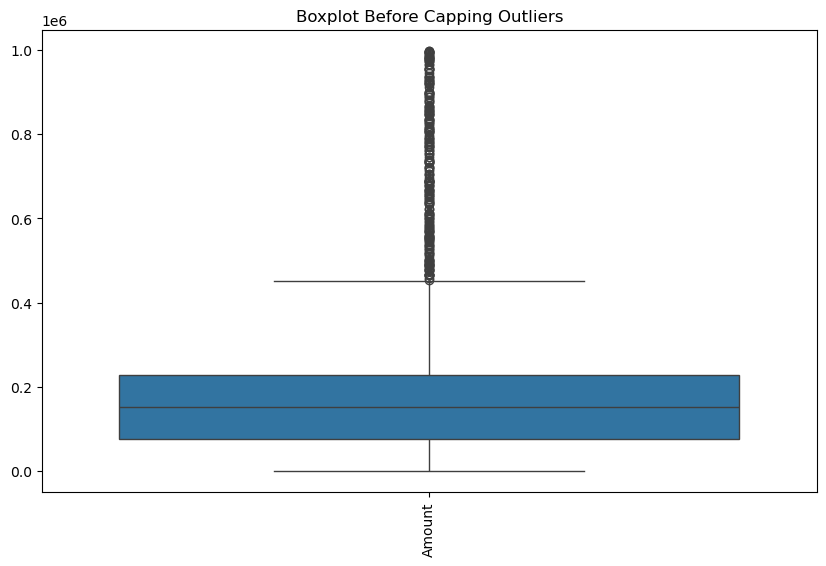

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot Before Capping Outliers")
plt.show()

# Capping Outliers using IQR Method (numeric columns only)

In [26]:
df_capped = df.copy()

# Automatically select only numeric columns
numeric_cols = df_capped.select_dtypes(include=['number']).columns

for col in numeric_cols:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_capped[col] = np.where(df_capped[col] < lower_bound, lower_bound, df_capped[col])
    df_capped[col] = np.where(df_capped[col] > upper_bound, upper_bound, df_capped[col])

df = df_capped  # Update the original dataframe with capped values


In [27]:
df = df.dropna(subset=[df.columns[-1]])

# Boxplot After Capping Outliers

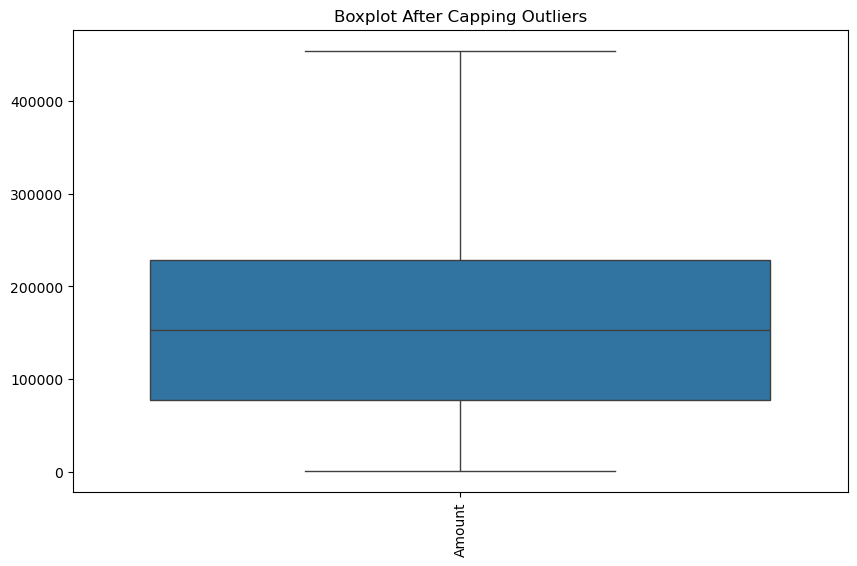

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot After Capping Outliers")
plt.show()

# Normalization

In [41]:
from sklearn.preprocessing import MinMaxScaler

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Apply MinMax scaling only to those columns
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


# Feature Selection

In [42]:
from sklearn.feature_selection import SelectKBest, f_classif

# Use only numeric features
X_numeric = X.select_dtypes(include=['number'])

# Adjust k dynamically
k_val = min(5, X_numeric.shape[1])  # Ensure k doesn't exceed number of features

selector = SelectKBest(score_func=f_classif, k=k_val)
X_selected = selector.fit_transform(X_numeric, y)

selected_features = X_numeric.columns[selector.get_support()]
print("Selected Features:", selected_features)


Selected Features: Index(['Amount'], dtype='object')


# Feature Engineering

In [43]:
import pandas as pd
import numpy as np


df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


# Transaction-Level Features (for Expense Prediction)

# Amount Bins
df['Amount_Bin'] = pd.cut(df['Amount'], bins=[0, 1000, 5000, 10000, np.inf],
                          labels=['Low', 'Medium', 'High', 'Very High'])

# Transaction Month
df['Transaction_Month'] = df['Date'].dt.month

# Weekend Flag
df['Is_Weekend'] = df['Date'].dt.dayofweek >= 5  # Saturday=5, Sunday=6

# Card Tier Level Encoding
card_tier_map = {'Silver': 1, 'Gold': 2, 'Platinum': 3}
df['Card_Tier_Level'] = df['Card Type'].map(card_tier_map)


# User-Level Features (for Card Tier Upgrade Recommendation)


# Aggregate by user-like fields (Card Type + City + Gender)
user_df = df.groupby(['Card Type', 'City', 'Gender']).agg({
    'Amount': 'mean',
    'Exp Type': lambda x: ((x == 'Travel') | (x == 'Bills')).sum(),
    'Date': 'count'
}).reset_index()

# Rename columns
user_df.rename(columns={
    'Amount': 'Avg_Amount',
    'Exp Type': 'HighEnd_Freq',
    'Date': 'Txn_Count'
}, inplace=True)

# Spend Diversity (how many types of expenses user transacts in)
spend_diversity = df.groupby(['Card Type', 'City', 'Gender'])['Exp Type'].nunique().reset_index(name='Spend_Diversity')
user_df = user_df.merge(spend_diversity, on=['Card Type', 'City', 'Gender'], how='left')

# Upgrade Label (binary target for model 2)
user_df['Upgrade_Label'] = ((user_df['Avg_Amount'] > 2500) & (user_df['HighEnd_Freq'] >= 3)).astype(int)

# Final view of user-level data
user_df.head()


Card Type              City Gender  Avg_Amount  HighEnd_Freq  Txn_Count  \
0      Gold   Achalpur, India      F    0.290162             1          2   
1      Gold   Achalpur, India      M    0.455220             2          2   
2      Gold   Adilabad, India      M    0.105891             0          1   
3      Gold  Adityapur, India      F    0.460533             0          1   
4      Gold  Adityapur, India      M    0.303095             0          2   

   Spend_Diversity  Upgrade_Label  
0                2              0  
1                1              0  
2                1              0  
3                1              0  
4                2              0

# Visualizations

## 1. Boxplot: Transaction Amount by Expense Type

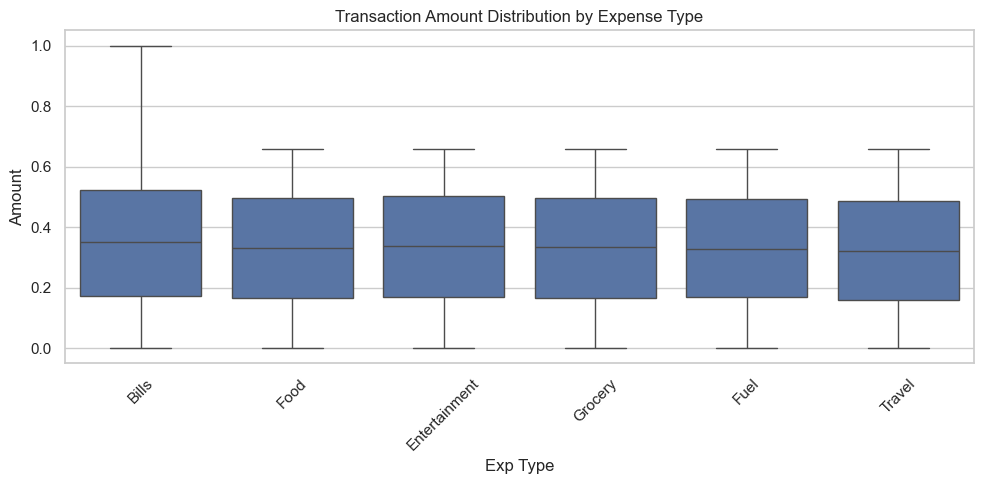

In [57]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Exp Type', y='Amount')
plt.title('Transaction Amount Distribution by Expense Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Bar Chart: Expense Count by Amount Bin

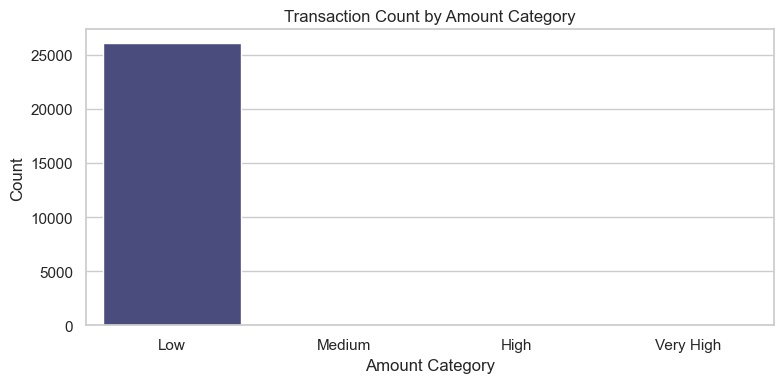

In [46]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Amount_Bin', palette='viridis')
plt.title('Transaction Count by Amount Category')
plt.xlabel('Amount Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## 3. Countplot: Transactions on Weekends vs Weekdays

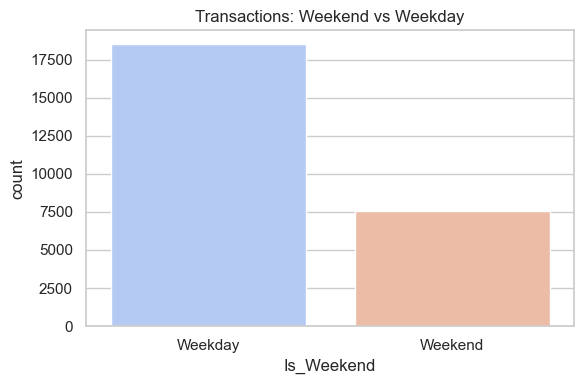

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Is_Weekend', palette='coolwarm')
plt.title('Transactions: Weekend vs Weekday')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.tight_layout()
plt.show()

## 4. Correlation Heatmap: User-Level Features

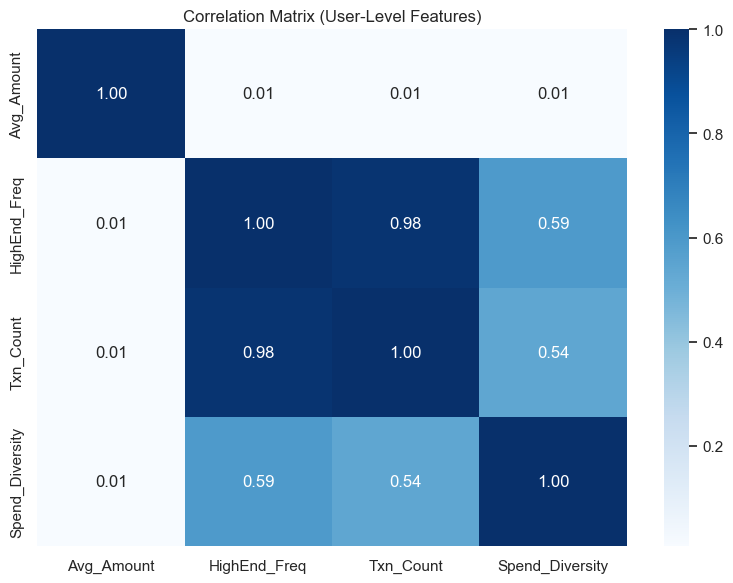

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(user_df[['Avg_Amount', 'HighEnd_Freq', 'Txn_Count', 'Spend_Diversity']].corr(), 
            annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix (User-Level Features)')
plt.tight_layout()
plt.show()

## 5. Histogram: Average Amount Distribution (User-Level)

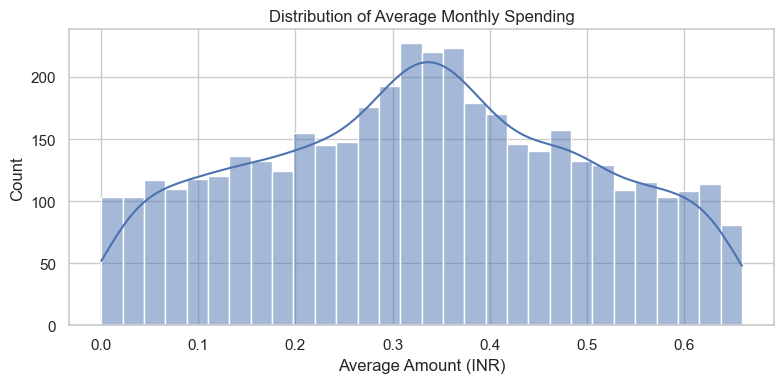

In [49]:
plt.figure(figsize=(8, 4))
sns.histplot(user_df['Avg_Amount'], kde=True, bins=30)
plt.title('Distribution of Average Monthly Spending')
plt.xlabel('Average Amount (INR)')
plt.tight_layout()
plt.show()


## 6. Barplot: High-End Category Frequency by Card Type

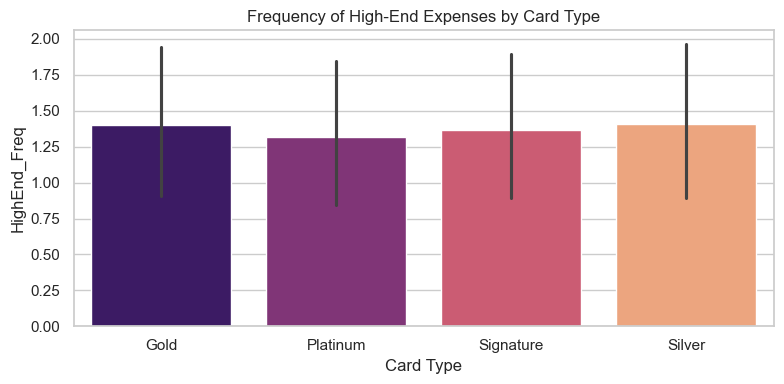

In [50]:
plt.figure(figsize=(8, 4))
sns.barplot(data=user_df, x='Card Type', y='HighEnd_Freq', palette='magma')
plt.title('Frequency of High-End Expenses by Card Type')
plt.tight_layout()
plt.show()

## 7.Pie Chart: Gender Distribution

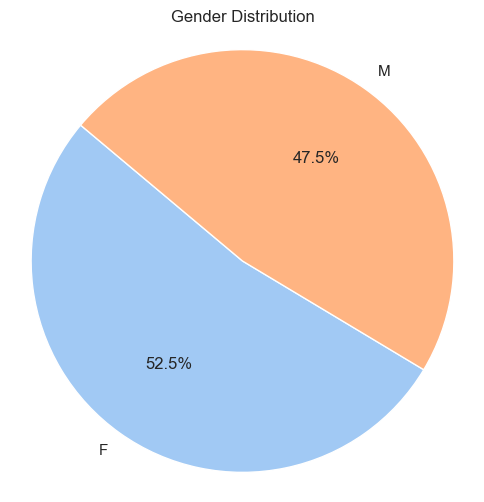

In [51]:
gender_counts = df['Gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

## 8.piechart:usage of different types of cards

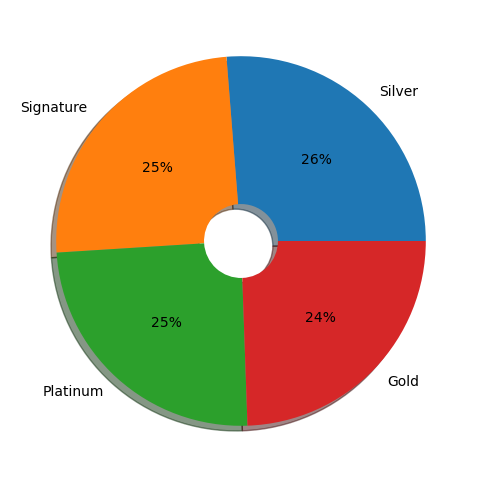

In [10]:
plt.figure(figsize=(6,6))
l=["Silver","Signature","Platinum","Gold"]
plt.pie(p_card,labels=l,shadow=True,autopct="%0.0f%%",textprops={'fontsize': 10},wedgeprops={"width":0.8})
plt.show()

In [11]:
#To find which expense type is most popular
p_exp = df['Exp Type'].value_counts()
p_exp

Exp Type
Food             5463
Fuel             5257
Bills            5078
Entertainment    4762
Grocery          4754
Travel            738
Name: count, dtype: int64

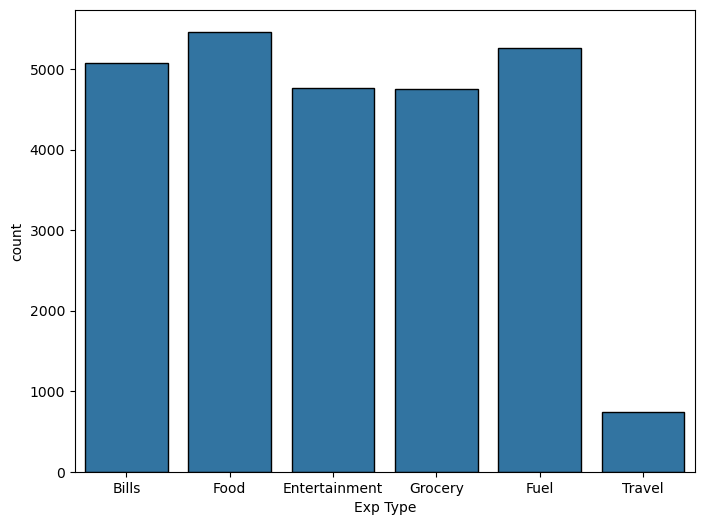

In [12]:
plt.figure(figsize=(8,6))
sns.countplot(x ="Exp Type",data=df,edgecolor="black")
plt.show()

In [13]:
#  Differentiating which gender spends more on credit card
m_gen = df["Gender"].value_counts()
m_gen

Gender
F    13680
M    12372
Name: count, dtype: int64

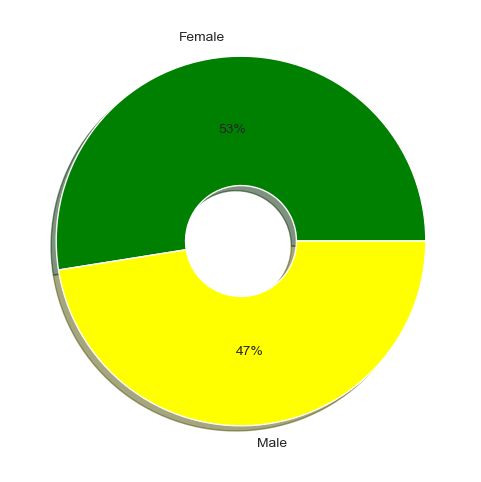

In [60]:
plt.figure(figsize=(6,6))
gen = ["Female","Male"]
plt.pie(m_gen,labels=gen,shadow=True,autopct="%0.0f%%",textprops={"fontsize":10},colors=["green","yellow"],wedgeprops={'width': 0.7})
plt.show()

In [15]:
# In which month of the year credit card usage is the highest
df["Month"] = df["Date"].dt.month_name()
p_mnth = df["Month"].value_counts()
p_mnth 

Month
January      2722
December     2702
October      2665
March        2622
November     2622
April        2587
May          2436
February     2433
August       1393
September    1321
July         1310
June         1239
Name: count, dtype: int64

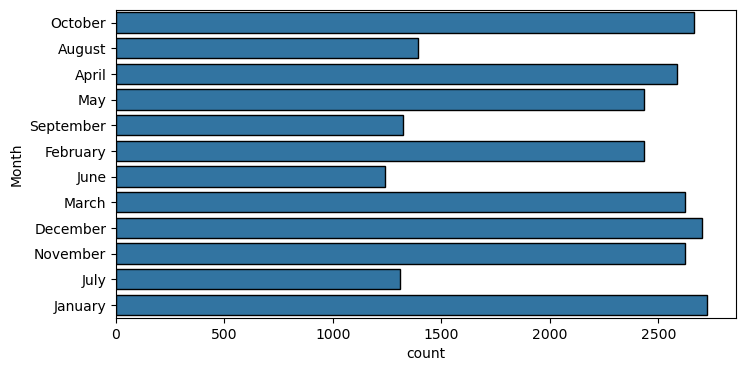

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(y="Month",data=df,edgecolor="black")
plt.show()

In [17]:
#Find top 5 cities of India which all spended credit card maximum.
max_city = pd.DataFrame(df['City'].value_counts())[0:5]
max_city

count
City                        
Bengaluru, India        3552
Greater Mumbai, India   3493
Ahmedabad, India        3491
Delhi, India            3482
Hyderabad, India         784

# Pie Chart: City Distribution (Top 5 cities only)

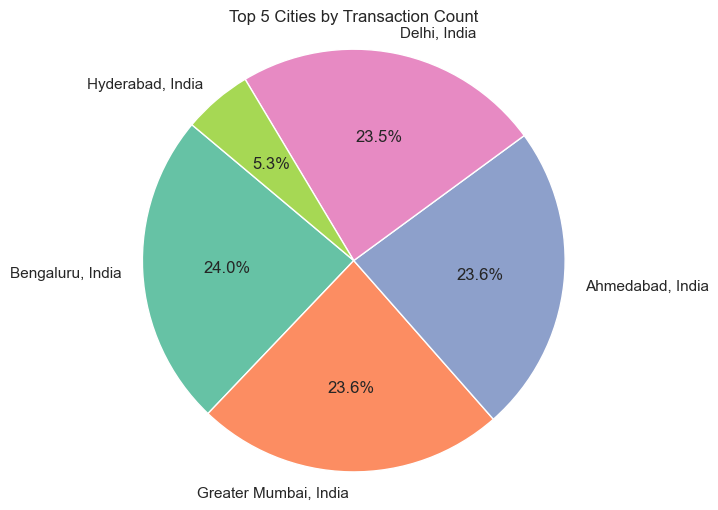

In [54]:
city_counts = df['City'].value_counts().nlargest(5)
plt.figure(figsize=(6, 6))
plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Top 5 Cities by Transaction Count')
plt.axis('equal')
plt.show()

In [19]:
#Which card type were mostly used by the Males and Females
card_gen = pd.DataFrame(df.groupby('Gender')['Card Type'].value_counts())
card_gen

count
Gender Card Type       
F      Silver      3773
       Signature   3368
       Gold        3287
       Platinum    3252
M      Platinum    3146
       Gold        3080
       Signature   3079
       Silver      3067

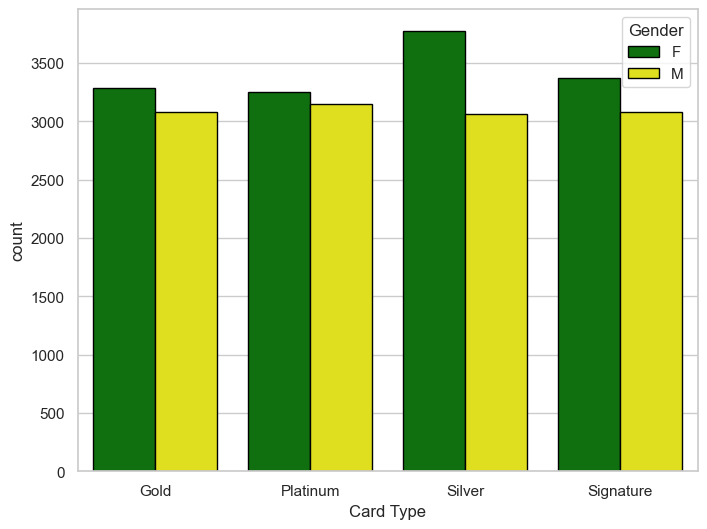

In [55]:
plt.figure(figsize=(8,6))
sns.countplot(x="Card Type",hue="Gender",data=df,palette=["green","yellow"],edgecolor="black")
plt.show()